In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import sys   #to ignore warnings
import os
sys.stderr = open(os.devnull, 'w')
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [119]:
df = pd.read_csv(r"C:\Users\NSHAT\crossrealms - intern\datasets\5G NDD\5G-NDD.csv")

In [120]:
df.shape

(1215890, 52)

In [121]:
df.head()

,Unnamed: 0,Seq,Dur,RunTime,Mean,Sum,Min,Max,Proto,sTos,...,sVid,dVid,SrcTCPBase,DstTCPBase,TcpRtt,SynAck,AckDat,Label,Attack Type,Attack Tool
0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,icmp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
1,1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,icmp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
2,2,3,4.998020,4.998020,4.998020,4.998020,4.998020,4.998020,udp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
3,3,4,4.998037,4.998037,4.998037,4.998037,4.998037,4.998037,udp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
4,4,5,4.999453,4.999453,4.999453,4.999453,4.999453,4.999453,udp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215890 entries, 0 to 1215889
Data columns (total 52 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Unnamed: 0   1215890 non-null  int64  
 1   Seq          1215890 non-null  int64  
 2   Dur          1215890 non-null  float64
 3   RunTime      1215890 non-null  float64
 4   Mean         1215890 non-null  float64
 5   Sum          1215890 non-null  float64
 6   Min          1215890 non-null  float64
 7   Max          1215890 non-null  float64
 8   Proto        1215890 non-null  object 
 9   sTos         1215676 non-null  float64
 10  dTos         272823 non-null   float64
 11  sDSb         1215676 non-null  object 
 12  dDSb         272823 non-null   object 
 13  sTtl         1215676 non-null  float64
 14  dTtl         272823 non-null   float64
 15  sHops        1215676 non-null  float64
 16  dHops        272823 non-null   float64
 17  Cause        1215890 non-null  object 
 18  To

In [123]:
df["Attack Type"].value_counts()

Attack Type
Benign            477737
UDPFlood          457340
HTTPFlood         140812
SlowrateDoS        73124
TCPConnectScan     20052
SYNScan            20043
UDPScan            15906
SYNFlood            9721
ICMPFlood           1155
Name: count, dtype: int64

### fixing column names

In [124]:
df.columns = df.columns.str.strip()

In [125]:
df.drop(columns={"Unnamed: 0","Seq"},inplace = True)

### removing duplicates

In [126]:
df.duplicated().sum()

np.int64(3358)

In [127]:
df.drop_duplicates(inplace= True)

In [128]:
df.duplicated().sum()

np.int64(0)

### Handling Missing Values

In [129]:
df.isna().sum()

Dur                  0
RunTime              0
Mean                 0
Sum                  0
Min                  0
Max                  0
Proto                0
sTos               214
dTos            939709
sDSb               214
dDSb            939709
sTtl               214
dTtl            939709
sHops              214
dHops           939709
Cause                0
TotPkts              0
SrcPkts              0
DstPkts              0
TotBytes             0
SrcBytes             0
DstBytes             0
Offset               0
sMeanPktSz           0
dMeanPktSz           0
Load                 0
SrcLoad              0
DstLoad              0
Loss                 0
SrcLoss              0
DstLoss              0
pLoss                0
SrcGap          933861
DstGap          933861
Rate                 0
SrcRate              0
DstRate              0
State                0
SrcWin          970112
DstWin         1035454
sVid           1099840
dVid           1210523
SrcTCPBase      933861
DstTCPBase 

In [130]:
#dropping unimportant feats with alot of missing values
drop_cols = ['dVid', 'sVid', 'SrcGap', 'DstGap', 'dTos', 'pLoss', 'Loss', 'SrcLoss', 'DstLoss']
df.drop(columns=drop_cols, inplace=True)

In [131]:
# numirical feats - fill by median
median_fill_cols = ['SrcTCPBase', 'DstTCPBase', 'SrcWin', 'DstWin', 'sTtl', 'dTtl', 'sHops', 'dHops']
for col in median_fill_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

In [132]:
# for the cols with very few missing values - filling with mode or constant
cols = ['sDSb', 'sTos']
for col in cols:
    if col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0]) 
        else:
            df[col] = df[col].fillna(df[col].median())  

### Label Encoding

In [133]:
le = LabelEncoder()
for col in ['Attack Tool']:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

In [134]:
# List your categorical columns
cat_cols = ['Proto', 'State', 'Cause', 'sDSb', 'dDSb', 'Label']

# Apply LabelEncoder to each
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))  # Ensure string type

In [135]:
# also saving to inverse later
df['Attack Type'] = le.fit_transform(df['Attack Type'].astype(str))
attack_type_classes = le.classes_

In [136]:
X= df.drop(columns={"Label", "Attack Type","Attack Tool"})
y = df["Attack Type"]

In [137]:
df["Attack Type"].value_counts()

Attack Type
0    475510
7    456214
1    140812
5     73124
6     20052
4     20043
8     15901
3      9721
2      1155
Name: count, dtype: int64

## Genetic algorithim for feature selection 

In [138]:
pip install genetic-selection

Note: you may need to restart the kernel to use updated packages.


In [139]:
from genetic_selection import GeneticSelectionCV

In [140]:

# sample from the data
X_sample = X.sample(n=100_000, random_state=42)
y_sample = y.loc[X_sample.index]

model = XGBClassifier(tree_method="hist", use_label_encoder=False, eval_metric="mlogloss")

selector = GeneticSelectionCV(
    estimator=model,
    cv=StratifiedKFold(3),
    scoring="accuracy",
    max_features=15,
    n_population=10,
    n_generations=5,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_jobs=-1,
    verbose=1
)

selector.fit(X_sample, y_sample)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                               
0  	10    	[ 0.774399  6.9       0.000911]	[ 0.124118  4.060788  0.000659]	[ 0.5518    1.        0.000166]	[  0.98262   13.         0.002284]
1  	6     	[  0.876499  10.         0.000476]	[ 0.10498   3.130495  0.000309]	[ 0.74535   5.        0.000166]	[  0.98267   14.         0.001193]
2  	5     	[  0.953836  12.4        0.00029 ]	[ 0.06621   1.8       0.000076]	[ 0.76439   8.        0.000166]	[  0.98267   14.         0.000434]
3  	5     	[-999.122291   13.6      1000.000259]	[ 3000.29257      1.496663  2999.999914]	[-10000.           10.            0.000262]	[     0.98276     16.       10000.     ]
4  	5     	[-999.11557    14.6      1000.000242]	[ 3000.29481      0.8       2999.999919]	[-10000.           13.            0.000209]	[     0.98276     16.       10000.     ]
5  	3     	[  0.98271   14.5     

GeneticSelectionCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=...
                                           learning_rate=None, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   max_features=15, n_generations=5, n_jobs=-1, n_population=10,
                   scoring='accuracy', verbose=1)

In [141]:
selected_features = X_sample.columns[selector.support_]
print(selected_features)

Index(['RunTime', 'Min', 'dDSb', 'sHops', 'Cause', 'SrcPkts', 'DstPkts',
       'DstBytes', 'Offset', 'sMeanPktSz', 'State', 'DstWin', 'SrcTCPBase',
       'AckDat'],
      dtype='object')


# splitting to train and test sets

In [142]:
X_selected = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Modeling

### XGBoost

In [143]:
xgb_clf = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

In [144]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [145]:
y_pred_xgb = xgb_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Accuracy: 0.9837901586345961
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     95102
           1       1.00      1.00      1.00     28163
           2       1.00      1.00      1.00       231
           3       1.00      1.00      1.00      1944
           4       1.00      1.00      1.00      4009
           5       1.00      0.99      1.00     14625
           6       1.00      1.00      1.00      4010
           7       0.96      1.00      0.98     91243
           8       1.00      1.00      1.00      3180

    accuracy                           0.98    242507
   macro avg       0.99      0.99      0.99    242507
weighted avg       0.98      0.98      0.98    242507



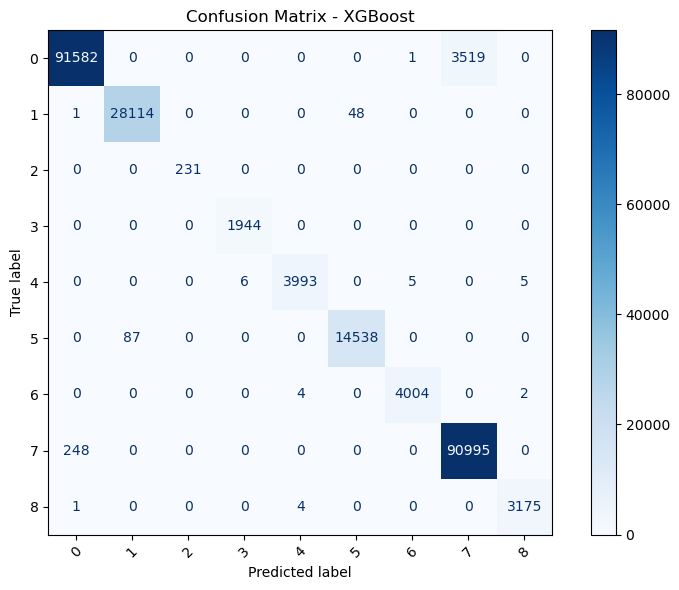

In [146]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_test.unique()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix - XGBoost")
plt.grid(False)
plt.tight_layout()
plt.show()

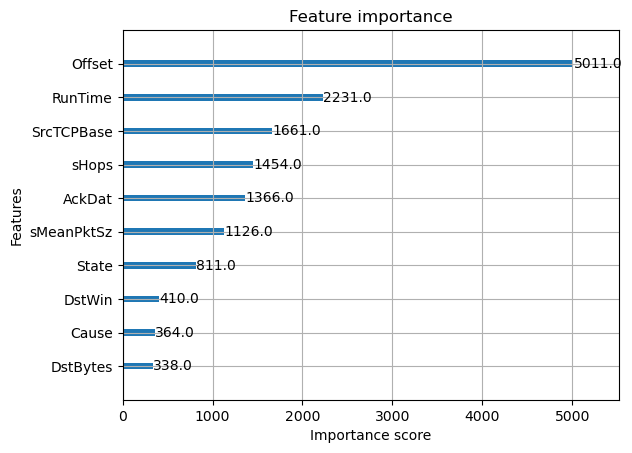

In [147]:
from xgboost import plot_importance

plot_importance(xgb_clf, max_num_features=10)
plt.show()


## k cross validation 

In [148]:
xgb_clf = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(xgb_clf, X_selected, y, cv=cv, scoring='accuracy', n_jobs=-1)

print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))
print("Standard deviation:", np.std(cv_scores))

Cross-validation accuracy scores: [0.98318399 0.98414066 0.984054   0.98345608 0.98355917]
Mean CV accuracy: 0.9836787812881707
Standard deviation: 0.0003641010048101096
